<hr></hr>
<h1>Task 3 - Decompose</h1>

In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

First, let us define the true values for the gates we aim to construct, so we may compare our results to them later. For any $n$-controlled gate, this is the same as the $2^{n+1}$ by $2^{n+1}$ Identity matrix with the last two rows permuted:

In [2]:
CCX_correct = np.eye(2**3)
CCX_correct[[-1, -2]] = CCX_correct[[-2, -1]]
print(CCX_correct)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [3]:
CCCX_correct = np.eye(2**4)
CCCX_correct[[-1, -2]] = CCCX_correct[[-2, -1]]
print(CCCX_correct)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [4]:
# True n-controlled not gate on n+1th qubit
def CnX_correct(n):
    CnX = np.eye(2**(n+1))
    CnX[[-1, -2]] = CnX[[-2, -1 ]]
    return CnX

Next, we define some useful operators and functions. These include some straightforward tools like the 2x2 identity matrix, $CX$ gate matrix, functions for multiple tensor products, non-adjacent $CX$ gates, and the parameterized single-qubit unitary given in the task. They also include nontrivial functions which implement a controlled $k$ th-root-pauli $X$ gate, as well as its hermitian conjugate. This implementation is based on the following construction from [1]:

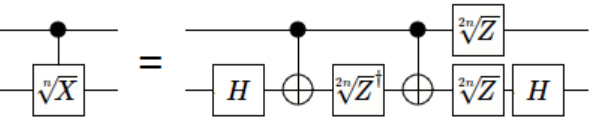

Here we replace '$n$' with '$k$' for disambiguity with the number of control qubits, and implement both $H$ as well as the $k$ th-roots of $Z$ and its hermitian conjugate using the **U(t, p, l)** function. Any constructions using these functions will only use $CX$ and parameterized gates, as desired. Thus, we can use these to build our multi-controlled-not gates.

In [5]:
### Useful Operators ###
id = np.eye(2)
cx = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [6]:
### Helper Functions ###

# Returns the kronecker product of many operators
def multikron(ops):
    if len(ops) >=3:
        return np.kron(ops[0], multikron(ops[1:]))
    else:
        return np.kron(ops[0], ops[1])

# Arbitrary CNOT matrix (supports nonadjacent qubits)
## c = control, t = target, n = number of qubits
def arb_cx(c, t, n):
    ops0 = [id] * n
    ops0[c-1] = np.array([[1,0],[0,0]])

    ops1 = [id] * n
    ops1[c-1] = np.array([[0,0],[0,1]])
    ops1[t-1] = np.array([[0,1],[1,0]])

    return multikron(ops0) + multikron(ops1)

# Returns parameterized unitary as given in the task
def U(t, p, l):
    return np.array([[np.cos(t/2), -np.exp(1j*l)*np.sin(t/2)],
                     [np.exp(1j*p)*np.sin(t/2), np.exp(1j*(p+l))*np.cos(t/2)]])

# Arbitrary Controlled-kth-root-X (supports nonadjacent qubits), and hermitian conjugate version
def krx(k, c, t, n):
    H = U(np.pi/2, 0, np.pi)
    Zrt = U(0, 0, np.pi/(2*k))
    Zrt_dag = U(0, -np.pi/(2*k) - np.pi, -np.pi)

    ops1 = [id] * n
    ops1[t-1] = H

    ops3 = [id] * n
    ops3[t-1] = Zrt_dag

    ops5 = [id] * n
    ops5[c-1] = Zrt
    ops5[t-1] = H @ Zrt

    return multikron(ops5) @ arb_cx(c,t,n) @ multikron(ops3) @ arb_cx(c,t,n) @ multikron(ops1)

def krx_dag(k, c, t, n):
    H = U(np.pi/2, 0, np.pi)
    Zrt = U(0, 0, np.pi/(2*k))
    Zrt_dag = U(0, -np.pi/(2*k) - np.pi, -np.pi)

    ops1 = [id] * n
    ops1[t-1] = H

    ops3 = [id] * n
    ops3[t-1] = Zrt

    ops5 = [id] * n
    ops5[c-1] = Zrt_dag
    ops5[t-1] = Zrt_dag @ H

    return multikron(ops1) @ arb_cx(c,t,n) @ multikron(ops3) @ arb_cx(c,t,n) @ multikron(ops5)

<h2> CCX </h2>
We construct CCX as a specific case of the arbitrary doubly controlled unitary construction given in [2]:

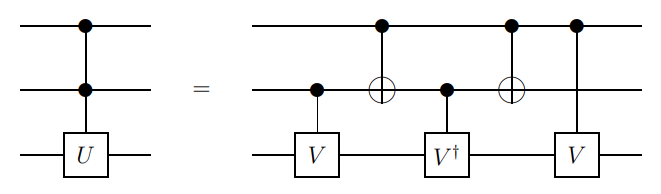

Here, $V$ must square to $U$, which for $CCX$ means $V = \sqrt{X}$. Thus, we can use our previous constructions for $C\sqrt{X}$ and $CX$ gates to construct $CCX$, as demonstrated below. Each 'timestep' contains matrix representations of the gates applied on all qubits at each step in the circuit. To test the construction, we multiply together all these steps and compare the total operator we get to the true one, like so:

$ \| CCX_{constructed} - CCX_{correct} \|_2 $

In [7]:
### CCX ###
timesteps = []

timesteps.append(krx(2,2,3,3))
timesteps.append(arb_cx(1,2,3))
timesteps.append(krx_dag(2,2,3,3))
timesteps.append(arb_cx(1,2,3))
timesteps.append(krx(2,1,3,3))

CCX = np.eye(2**3)
for timestep in timesteps:
    CCX = timestep @ CCX

We can verify correctness by taking the operator-2 norm of the difference between our construction and the true CCX matrix, and confirming that it is extremely close to zero:

In [8]:
print(np.linalg.norm(CCX - CCX_correct, ord=2))

1.055376132229156e-15


<hr></hr>
<h2> CCCX </h2>
Next, we employ a similar process for $CCCX-$ specifying a particular $CCCU$ instace using a cosntruction from [2]:

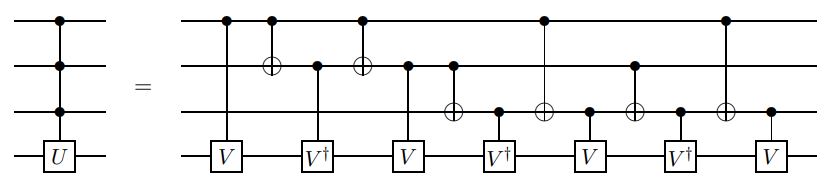

In this case, we require that $V^4 = U = X $, so the $CV$ s  here will be $C\sqrt[4]{X}$ s. Again, we use our contrusction for arbitrary controlled- $k$ th-root-X gates to implement these. We also verify yet again that the operator 2-norm of the difference between our construction and the true value is very small.

In [9]:
### CCCX ###
timesteps = []

timesteps.append(krx(4, 1, 4, 4))
timesteps.append(arb_cx(1, 2, 4))
timesteps.append(krx_dag(4, 2, 4, 4))
timesteps.append(arb_cx(1, 2, 4))
timesteps.append(krx(4, 2, 4, 4))
timesteps.append(arb_cx(2, 3, 4))
timesteps.append(krx_dag(4, 3, 4, 4))
timesteps.append(arb_cx(1, 3, 4))
timesteps.append(krx(4, 3, 4, 4))
timesteps.append(arb_cx(2, 3, 4))
timesteps.append(krx_dag(4, 3, 4, 4))
timesteps.append(arb_cx(1, 3, 4))
timesteps.append(krx(4, 3, 4, 4))

CCCX = np.eye(2**4)
for timestep in timesteps:
    CCCX = timestep @ CCCX

print(np.linalg.norm(CCCX - CCCX_correct, ord=2))


2.5075781074669538e-15


<hr></hr>
<h2>Arbitrarilyy Multi-controlled X gate</h2>

Finally, we use the following cosntruction for an arbitrarily-many-controlled-U from [2] as the blueprint for our arbitrarily-many-controlled-not:

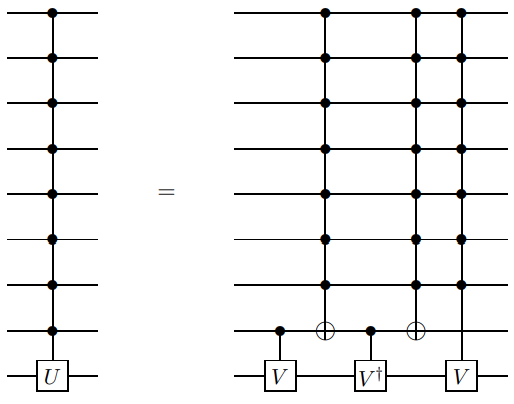

Here, we require again $V^2 = U = X$, i.e. $V = \sqrt{X}$. The first and third timesteps can be implemented more or less the same as they were for $CCX$, with the krx() function. For the $n-1$ -controlled nots and $V$ s, we will require some recursive function, which can implement either $-$ meaning it must be able to specify an arbitrary root of $X$, $k$. Moreover, given that the two  $n-1$ -controlled nots do not act on the same qubit as the $n-1$ -controlled $V$, these functions must also specify a target qubit, which we call $j$. Such a function is implemented as **CnrX(n, k, j)**. The base case for this recursive function is $n = 1$, a $CNOT$ gate. To use it specifically for n-controlled-nots, we define a wrapper function **CnX(n)** which applies the "first root" of $X$ (i.e. $X$ itself) to the $n+1$ th qubit, conditioned on the first $n$ qubits.

In [10]:
### n-controlled kth-root-X gate on jth qubit ###
def CnrX(n, k, j):
    if n >=2 :
        output = np.eye(2**j)
        timesteps = []
        timesteps.append(krx(2*k, n, j, j))
        timesteps.append(multikron([CnrX(n-1, 1, n)] + [id] * (j - n)))
        timesteps.append(krx_dag(2*k, n, j, j))
        timesteps.append(multikron([CnrX(n-1, 1, n)] + [id] * (j - n)))
        timesteps.append(CnrX(n-1, 2*k, j))
        
        for timestep in timesteps:
            output = timestep @ output

        return output
    
    else:
        return krx(k, 1, j, j)

### n-controlled not gate ###
def CnX(n):
    return CnrX(n, 1, n+1)

We can now test **CnX()** for various values of $n$ by comparing it to the output of **CnX_correct()**, again using the operator 2-norm of their difference. Below are the results for all $n \in [1,9] $:

In [11]:
errors = []
for n in range(1, 11):
    errors.append(np.linalg.norm(CnX(n) - CnX_correct(n), ord=2))
    print('For an '+str(n)+'-controlled not gate, we have op2-norm error: '+str(errors[-1]))

For an 1-controlled not gate, we have op2-norm error: 3.6462582309242003e-16
For an 2-controlled not gate, we have op2-norm error: 1.6068590775900611e-15
For an 3-controlled not gate, we have op2-norm error: 4.861154338146604e-15
For an 4-controlled not gate, we have op2-norm error: 1.4458925647940633e-14
For an 5-controlled not gate, we have op2-norm error: 4.316927405939656e-14


For an 6-controlled not gate, we have op2-norm error: 1.2952354382632386e-13
For an 7-controlled not gate, we have op2-norm error: 3.8870678742496605e-13
For an 8-controlled not gate, we have op2-norm error: 1.165283540110665e-12
For an 9-controlled not gate, we have op2-norm error: 3.4972120617108844e-12
For an 10-controlled not gate, we have op2-norm error: 1.0491784966970242e-11


Observe that although the norm error in increasing, even for a 10-controlled-not, it is negligible (order of $10^{-12}$). Let us plot these errors to get a better idea of how the performance of this implementation scales with system size.

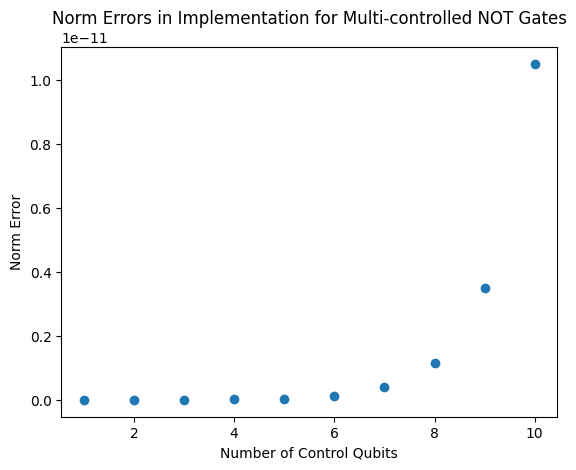

In [17]:
ctrls = list(range(1,11))

plt.scatter(ctrls, errors)
plt.xlabel('Number of Control Qubits')
plt.ylabel('Norm Error')
plt.title('Norm Errors in Implementation for Multi-controlled NOT Gates')
plt.show()

While still negible up to 10-controlled-nots, that there looks to be exponential growth in the error. This warrants some further analysis. If we extrapolate based on these data, we get some idea of the size of the systems for which we could simulate the gates with trivial norm errors.

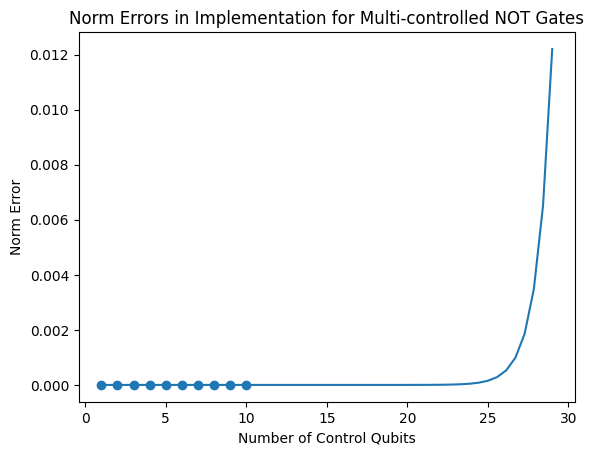

In [18]:
### The errors appear to be exponentially increasing with the number of control qubits, 
###   so we fit to an exponential function
def f(x, a, b):
    return a*np.exp(b*x)

ctrls = list(range(1,11))
popt, pcov = cf(f, ctrls, errors)

test = np.linspace(1,29)
plt.scatter(ctrls, errors)
plt.plot(test, f(test, *popt))
plt.xlabel('Number of Control Qubits')
plt.ylabel('Norm Error')
plt.title('Norm Errors in Implementation for Multi-controlled NOT Gates')
plt.show()

As seen above, our extrapolation predicts that we could implement up to a $C^{28}NOT$ before we even break a 1% norm error. While this extrapolation is certainly not exact, it provides evidence that our implementation sucessfully simulates a $C^{n}NOT$ gate for many $n$ using only $CNOT$ and paramaterized single-qubit unitary gates.

<hr></hr>
<h2> References </h2>

[1] https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html

[2] https://arxiv.org/pdf/quant-ph/9503016.pdf